preparation

In [43]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

step1: load data

In [44]:
# 读取消防事件数据
fire_data = pd.read_csv('LFB Incident data from 2018 onwards.csv', usecols=['FirstPumpArriving_AttendanceTime', 'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'ProperCase'])
# 使用实际列名 IncGeo_WardName  # 只保留 FirstPumpArriving_AttendanceTime, Borough 字段
print("Fire data columns:", fire_data.columns)
# 读取伦敦的 ward 边界地理数据
Borough_geo = gpd.read_file('ESRI/London_Borough_Excluding_MHW.shp')  # ESRI 文件夹内的伦敦 ward 边界数据  # shapefile 包含伦敦所有 ward 的边界信息
print("Borough geo data columns:", Borough_geo.columns)

Fire data columns: Index(['IncGeo_BoroughCode', 'IncGeo_BoroughName', 'ProperCase',
       'FirstPumpArriving_AttendanceTime'],
      dtype='object')
Borough geo data columns: Index(['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009',
       'SUB_2006', 'geometry'],
      dtype='object')


step2: clean data

In [45]:
fire_data.rename(columns={'IncGeo_BoroughName': 'Borough'}, inplace=True)
fire_data['Borough'] = fire_data['Borough'].str.strip().str.upper() 

In [46]:
# 使用 IQR 方法去除异常值
Q1 = fire_data['FirstPumpArriving_AttendanceTime'].quantile(0.25)
Q3 = fire_data['FirstPumpArriving_AttendanceTime'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 过滤掉异常值
fire_data = fire_data[(fire_data['FirstPumpArriving_AttendanceTime'] >= lower_bound) & (fire_data['FirstPumpArriving_AttendanceTime'] <= upper_bound)]

step3: prepare

In [47]:
# 计算每个 ward 的平均响应时间
Borough_response_time = fire_data.groupby('Borough')['FirstPumpArriving_AttendanceTime'].mean().reset_index()
Borough_response_time.columns = ['Borough', 'AvgResponseTime']

In [48]:
# Step 3: 将平均响应时间数据合并到地理数据中
Borough_geo.rename(columns={'NAME': 'Borough'}, inplace=True)

Borough_geo['Borough'] = Borough_geo['Borough'].str.strip().str.upper()  # 确保地理数据中的 Ward 名称一致
Borough_geo = Borough_geo.merge(Borough_response_time, on='Borough', how='left')  # 合并数据，left join 保留所有 ward

<Figure size 1000x1200 with 0 Axes>

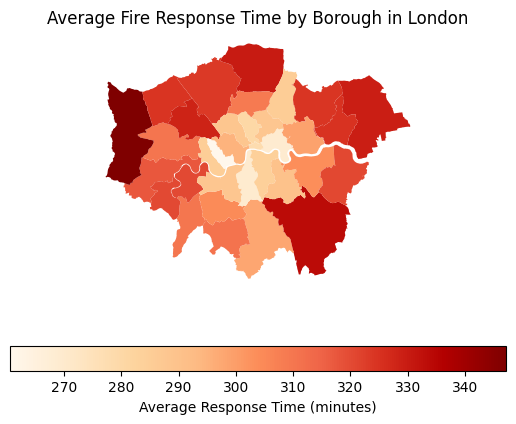

In [49]:
# Step 4: 可视化消防响应时间在各个 ward 的分布情况
plt.figure(figsize=(10, 12))
Borough_geo.plot(column='AvgResponseTime', cmap='OrRd', legend=True, 
               legend_kwds={'label': "Average Response Time (minutes)", 'orientation': "horizontal"})
plt.title('Average Fire Response Time by Borough in London')
plt.axis('off')
plt.show()


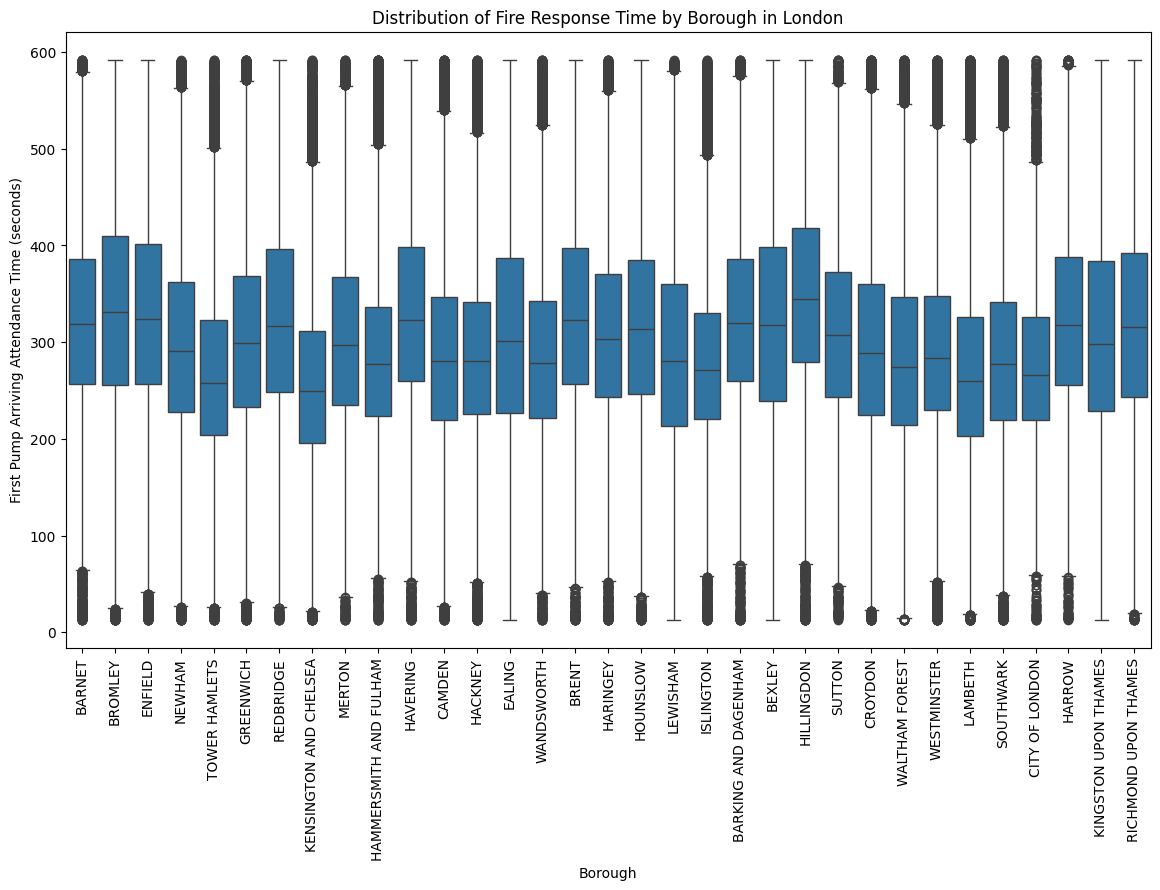

In [50]:
# Step 5: 使用 Seaborn 进一步分析响应时间分布
# 例如，绘制箱线图以查看不同 borough 之间的响应时间差异
plt.figure(figsize=(14, 8))
sns.boxplot(data=fire_data, x='Borough', y='FirstPumpArriving_AttendanceTime')
plt.xticks(rotation=90)
plt.xlabel('Borough')
plt.ylabel('First Pump Arriving Attendance Time (seconds)')
plt.title('Distribution of Fire Response Time by Borough in London')
plt.show()